In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import logging
import sys

# Configure basic logging to stream to sys.stdout
# This ensures logs are visible in the Jupyter output
logging.basicConfig(
    stream=sys.stdout,
    level=logging.INFO,  # Set the desired logging level (e.g., DEBUG, INFO, WARNING, ERROR, CRITICAL)
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S"
)

# Get a logger instance (optional, but good practice for specific loggers)
logger = logging.getLogger(__name__)

logger.info("This is an informational message.")


2025-06-22 10:16:30 - INFO - __main__ - This is an informational message.


In [16]:
# ======================
# 1. 市场数据模拟（含Level 2订单簿）
# ======================
class MarketSimulator:
    def __init__(self, ticker, base_price, volatility, daily_volume):
        self.ticker = ticker
        self.price = base_price
        self.volatility = volatility  # 日波动率（%）
        self.daily_volume = daily_volume  # 日均交易量（股）
        self.order_book = self._init_order_book()
        
    def _init_order_book(self):
        """初始化五档订单簿"""
        return {
            'bid': [{'price': self.price * (1 - i*0.001), 'qty': np.random.randint(1000,5000)} for i in range(1,6)],
            'ask': [{'price': self.price * (1 + i*0.001), 'qty': np.random.randint(1000,5000)} for i in range(1,6)]
        }
    
    def update_market(self, executed_volume=0):
        """模拟市场变化：价格波动+订单簿更新"""
        # 价格随机游走（几何布朗运动）
        delta = self.volatility / np.sqrt(252) * np.random.randn()
        self.price *= (1 + delta)
        
        # 更新订单簿（随机增减档位）
        for side in ['bid', 'ask']:
            for level in self.order_book[side]:
                level['qty'] = max(100, int(level['qty'] * np.random.uniform(0.8, 1.2)))
                level['price'] *= (1 + np.random.uniform(-0.0005, 0.0005))
        
        # 成交量消耗
        remaining_vol = self.daily_volume * 0.2  # 假设每分钟消耗20%日成交量
        return max(0, remaining_vol - executed_volume)



In [17]:
# ======================
# 2. VWAP算法实现
# ======================
def vwap_algorithm(target_shares, market_data, duration_min=240):
    """
    VWAP算法执行器
    :param target_shares: 目标交易量（股）
    :param market_data: MarketSimulator实例
    :param duration_min: 交易总时长（分钟）
    """
    logger.info(f"\n=== 启动VWAP算法 [{market_data.ticker}] ===")
    logger.info(f"目标: {target_shares/10000:.1f}万股 | 时长: {duration_min}分钟")
    
    # 历史成交量分布预测（简化版：正态分布）
    volume_profile = [np.exp(-(x-120)**2/(2*60**2)) for x in range(duration_min)]
    volume_profile = [v/sum(volume_profile)*target_shares for v in volume_profile]
    
    executed = 0
    results = []
    for minute in range(duration_min):
        # 获取当前市场状态
        current_vol = volume_profile[minute] * np.random.uniform(0.9, 1.1)  # 加入10%随机扰动
        remaining_vol = market_data.update_market(current_vol)
        
        # 计算应下单量（不超过档位深度20%）
        bid_depth = sum(level['qty'] for level in market_data.order_book['bid'][:3])  # 前三档买方深度
        ask_depth = sum(level['qty'] for level in market_data.order_book['ask'][:3])  # 前三档卖方深度
        max_order_qty = min(bid_depth, ask_depth) * 0.2
        
        # 执行订单（买入为例）
        order_qty = min(max_order_qty, current_vol, target_shares - executed)
        if order_qty > 0:
            # 模拟按卖一价成交
            execute_price = market_data.order_book['ask'][0]['price']
            executed += order_qty
            results.append({
                'time': minute,
                'price': execute_price,
                'shares': order_qty,
                'cum_shares': executed
            })
            logger.debug(f"Min {minute:03d}: 成交 {order_qty/10000:.1f}万股 @ {execute_price:.2f} | 进度: {executed/target_shares*100:.1f}%")
    
    # 结果分析
    avg_price = sum(r['price']*r['shares'] for r in results) / executed
    logger.info(f"执行完成! 均价: {avg_price:.2f} | 理论VWAP: {market_data.price:.2f}")
    
    # 可视化
    plot_execution(results, "VWAP Algorithm")
    return results



In [ ]:
# ======================
# 3. TWAP算法实现
# ======================
def twap_algorithm(target_shares, market_data, duration_min=240, volatility_threshold=0.3):
    """
    TWAP算法执行器（带波动率调整）
    :param volatility_threshold: 波动率阈值，高于此值则减速
    """
    logger.info(f"\n=== 启动TWAP算法 [{market_data.ticker}] ===")
    logger.info(f"目标: {target_shares/10000:.1f}万股 | 时长: {duration_min}分钟")
    
    base_order = target_shares / duration_min
    executed = 0
    results = []
    prev_price = market_data.price
    
    for minute in range(duration_min):
        # 更新市场状态
        remaining_vol = market_data.update_market()
        
        # 波动率检测（1分钟波动）
        current_volatility = abs(market_data.price / prev_price - 1)
        prev_price = market_data.price
        
        # 动态调整订单量（高波动时减速）
        adjustment = 1.0
        if current_volatility > volatility_threshold / 100:  # 转换为小数
            adjustment = 0.5
            logger.debug(f"Min {minute:03d}: 高波动({current_volatility*100:.2f}%)，降速50%")
        
        order_qty = base_order * adjustment
        order_qty = min(order_qty, target_shares - executed, remaining_vol)
        
        if order_qty > 0:
            # 模拟按买卖中间价成交
            bid_top = market_data.order_book['bid'][0]['price']
            ask_top = market_data.order_book['ask'][0]['price']
            execute_price = (bid_top + ask_top) / 2
            executed += order_qty
            results.append({
                'time': minute,
                'price': execute_price,
                'shares': order_qty,
                'cum_shares': executed
            })
            logger.debug(f"Min {minute:03d}: 成交 {order_qty/10000:.1f}万股 @ {execute_price:.2f} | 进度: {executed/target_shares*100:.1f}%")
    
    # 结果分析
    avg_price = sum(r['price']*r['shares'] for r in results) / executed
    logger.info(f"执行完成! 均价: {avg_price:.2f} | 最终市价: {market_data.price:.2f}")
    
    # 可视化
    plot_execution(results, "TWAP Algorithm")
    return results



In [19]:
# ======================
# 4. Iceberg算法实现
# ======================
def iceberg_algorithm(target_shares, market_data, visible_ratio=0.1, duration_min=240):
    """
    Iceberg算法执行器
    :param visible_ratio: 可见部分比例
    """
    logger.info(f"\n=== 启动Iceberg算法 [{market_data.ticker}] ===")
    logger.info(f"目标: {target_shares/10000:.1f}万股 | 可见比例: {visible_ratio*100:.0f}%")
    
    executed = 0
    hidden_shares = target_shares
    results = []
    order_id = 0
    
    for minute in range(duration_min):
        # 更新市场状态
        remaining_vol = market_data.update_market()
        
        if hidden_shares <= 0:
            break
            
        # 计算可见订单量（不超过前三档深度的10%）
        visible_qty = min(
            sum(level['qty'] for level in market_data.order_book['ask'][:3]) * visible_ratio,
            hidden_shares * 0.01  # 每次最多释放1%的总量
        )
        
        # 挂出可见订单
        if visible_qty > 1000:  # 最小订单量
            order_id += 1
            logger.debug(f"Min {minute:03d}: 挂出可见单 #{order_id} {visible_qty/10000:.1f}万股 @ {market_data.order_book['ask'][0]['price']:.2f}")
            
            # 模拟订单成交（假设部分成交）
            execute_qty = min(visible_qty, remaining_vol * 0.8)  # 假设80%成交率
            execute_price = market_data.order_book['ask'][0]['price']
            executed += execute_qty
            hidden_shares -= execute_qty
            results.append({
                'time': minute,
                'price': execute_price,
                'shares': execute_qty,
                'cum_shares': executed
            })
            logger.debug(f"    成交 {execute_qty/10000:.1f}万股 | 剩余隐藏量: {hidden_shares/10000:.1f}万股")
    
    # 未完成部分转为市价单
    if hidden_shares > 0:
        execute_price = market_data.order_book['ask'][0]['price'] * 1.005  # 溢价0.5%扫货
        executed += hidden_shares
        results.append({
            'time': duration_min,
            'price': execute_price,
            'shares': hidden_shares,
            'cum_shares': executed
        })
        logger.debug(f"转为市价单! 成交 {hidden_shares/10000:.1f}万股 @ {execute_price:.2f}")
    
    # 结果分析
    avg_price = sum(r['price']*r['shares'] for r in results) / executed
    logger.info(f"执行完成! 均价: {avg_price:.2f} | 隐藏量比例: {(target_shares - results[0]['shares'])/target_shares*100:.1f}%")
    
    # 可视化
    plot_execution(results, "Iceberg Algorithm")
    return results



In [20]:
# ======================
# 5. Dark Pool算法实现
# ======================
class DarkPool:
    def __init__(self, name, liquidity_factor):
        self.name = name
        self.liquidity_factor = liquidity_factor  # 流动性系数
        self.orders = []  # 待匹配订单
        
    def match_orders(self):
        """尝试匹配买卖订单（简化版：随机匹配）"""
        matched = []
        buy_orders = [o for o in self.orders if o['side'] == 'buy']
        sell_orders = [o for o in self.orders if o['side'] == 'sell']
        
        while buy_orders and sell_orders:
            buy = buy_orders.pop(0)
            sell = sell_orders.pop(0)
            match_qty = min(buy['qty'], sell['qty'])
            match_price = (buy['price'] + sell['price']) / 2  # 中间价成交
            
            # 记录成交
            matched.append({
                'buy_order': buy['id'],
                'sell_order': sell['id'],
                'qty': match_qty,
                'price': match_price
            })
            
            # 更新剩余量
            buy['qty'] -= match_qty
            sell['qty'] -= match_qty
            if buy['qty'] > 0: buy_orders.insert(0, buy)
            if sell['qty'] > 0: sell_orders.insert(0, sell)
        
        return matched

def darkpool_algorithm(target_shares, market_data, dark_pools, duration_min=240):
    """
    Dark Pool算法执行器（多池路由）
    """
    logger.info(f"\n=== 启动Dark Pool算法 [{market_data.ticker}] ===")
    logger.info(f"目标: {target_shares/10000:.1f}万股 | 可用暗池: {', '.join(dp.name for dp in dark_pools)}")
    
    executed = 0
    results = []
    order_id = 0
    
    for minute in range(duration_min):
        # 更新市场状态
        market_data.update_market()
        
        if executed >= target_shares:
            break
            
        # 创建暗池订单（买入）
        order_qty = min(target_shares - executed, 50000)  # 每单最大5万股
        order_id += 1
        order = {
            'id': order_id,
            'ticker': market_data.ticker,
            'side': 'buy',
            'qty': order_qty,
            'price': market_data.price * (1 + np.random.uniform(-0.005, 0.005))  # ±0.5%价格容忍度
        }
        
        # 选择暗池（按流动性系数加权）
        pool_weights = [dp.liquidity_factor for dp in dark_pools]
        chosen_pool = np.random.choice(dark_pools, p=pool_weights/sum(pool_weights))
        chosen_pool.orders.append(order)
        logger.info(f"Min {minute:03d}: 订单#{order_id}发送至 {chosen_pool.name} | {order_qty/10000:.1f}万股")
        
        # 所有暗池尝试匹配
        for pool in dark_pools:
            matches = pool.match_orders()
            for match in matches:
                # 记录成交
                executed += match['qty']
                results.append({
                    'time': minute,
                    'price': match['price'],
                    'shares': match['qty'],
                    'cum_shares': executed,
                    'pool': pool.name
                })
                logger.info(f"    暗池成交: {match['qty']/10000:.1f}万股 @ {match['price']:.2f} ({pool.name})")
    
    # 未完成部分转明盘
    if executed < target_shares:
        remaining = target_shares - executed
        execute_price = market_data.order_book['ask'][0]['price'] * 1.01  # 溢价1%扫货
        executed += remaining
        results.append({
            'time': duration_min,
            'price': execute_price,
            'shares': remaining,
            'cum_shares': executed,
            'pool': 'OPEN MARKET'
        })
        logger.info(f"转明盘成交: {remaining/10000:.1f}万股 @ {execute_price:.2f}")
    
    # 结果分析
    avg_price = sum(r['price']*r['shares'] for r in results) / executed
    dark_percent = sum(r['shares'] for r in results if 'pool' in r and r['pool'] != 'OPEN MARKET') / executed * 100
    logger.info(f"执行完成! 均价: {avg_price:.2f} | 暗池成交比例: {dark_percent:.1f}%")
    
    # 可视化
    plot_execution(results, "Dark Pool Algorithm", dark_pools=[dp.name for dp in dark_pools])
    return results



In [21]:
# ======================
# 可视化工具函数
# ======================
def plot_execution(results, title, dark_pools=None):
    """绘制算法执行结果"""
    plt.figure(figsize=(12, 8))
    
    # 价格-时间图
    times = [r['time'] for r in results]
    prices = [r['price'] for r in results]
    cum_shares = [r['cum_shares'] for r in results]
    
    plt.subplot(2, 1, 1)
    plt.plot(times, prices, 'bo-', label='execution price')
    plt.xlabel('time (min)')
    plt.ylabel('price')
    plt.title(f'{title} - execution price trend')
    plt.grid(True)
    
    # 累计成交量图
    plt.subplot(2, 1, 2)
    plt.step(times, cum_shares, 'g-', where='post', label='cumulative price')
    plt.fill_between(times, 0, cum_shares, alpha=0.1, color='green')
    plt.xlabel('time (min)')
    plt.ylabel('Cumulative Shares')
    plt.title('Trade Execution Progress')
    plt.grid(True)
    
    # 暗池标注
    if dark_pools:
        for r in results:
            if 'pool' in r and r['pool'] != 'OPEN MARKET':
                plt.annotate(r['pool'], (r['time'], r['cum_shares']), 
                            textcoords="offset points", xytext=(0,10), ha='center')
    
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_')}.png")
    plt.show()



In [22]:
# ======================
# 主程序：算法演示
# ======================
# 创建模拟市场环境
msft_market = MarketSimulator(ticker="MSFT", base_price=300, volatility=1.5, daily_volume=5000000)


2025-06-22 10:16:31 - INFO - __main__ - 
=== 启动VWAP算法 [MSFT] ===
2025-06-22 10:16:31 - INFO - __main__ - 目标: 300.0万股 | 时长: 240分钟
2025-06-22 10:16:31 - INFO - __main__ - 执行完成! 均价: 300.94 | 理论VWAP: 267.42


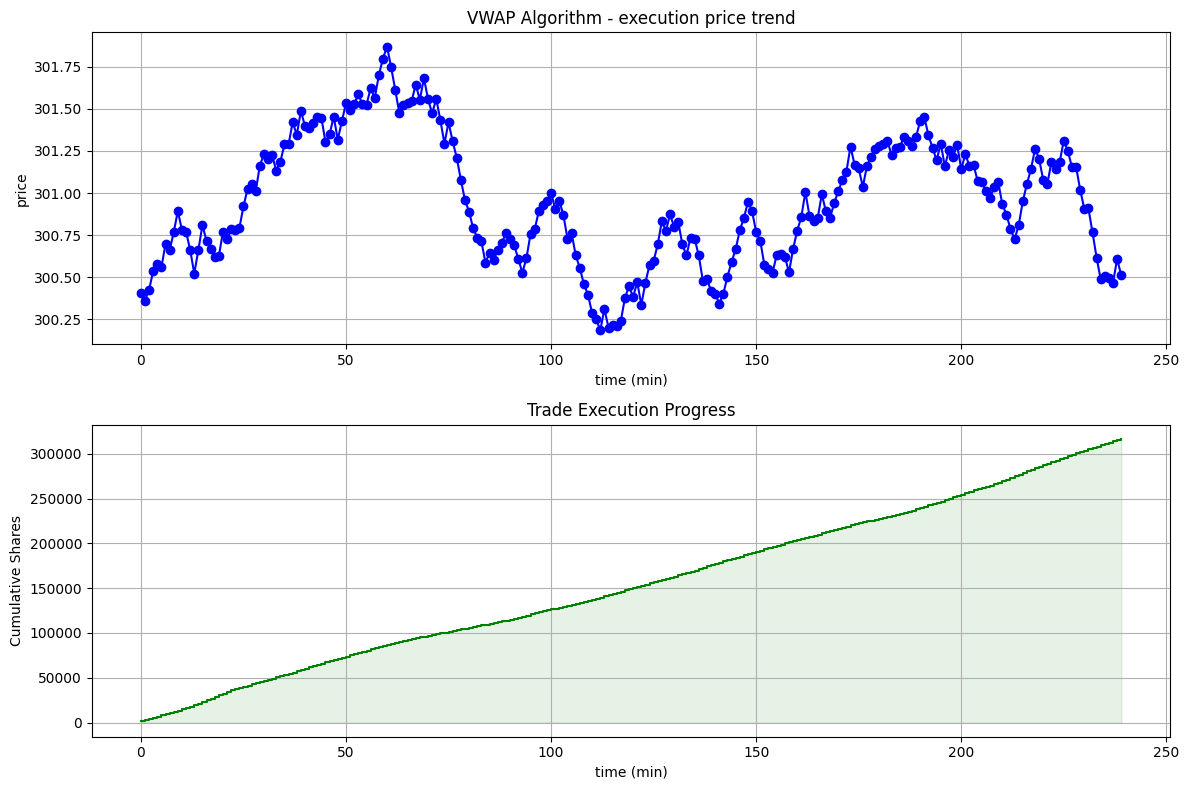

In [23]:
# 执行VWAP算法（300万股，4小时）
vwap_results = vwap_algorithm(target_shares=3000000, market_data=msft_market)

2025-06-22 10:16:31 - INFO - __main__ - 
=== 启动TWAP算法 [MSFT] ===
2025-06-22 10:16:31 - INFO - __main__ - 目标: 300.0万股 | 时长: 240分钟
2025-06-22 10:16:31 - INFO - __main__ - Min 000: 高波动(8.32%)，降速50%
2025-06-22 10:16:31 - INFO - __main__ - Min 001: 高波动(2.86%)，降速50%
2025-06-22 10:16:31 - INFO - __main__ - Min 002: 高波动(5.40%)，降速50%
2025-06-22 10:16:31 - INFO - __main__ - Min 003: 高波动(3.36%)，降速50%
2025-06-22 10:16:31 - INFO - __main__ - Min 004: 高波动(2.39%)，降速50%
2025-06-22 10:16:31 - INFO - __main__ - Min 006: 高波动(2.37%)，降速50%
2025-06-22 10:16:31 - INFO - __main__ - Min 007: 高波动(10.74%)，降速50%
2025-06-22 10:16:31 - INFO - __main__ - Min 008: 高波动(5.52%)，降速50%
2025-06-22 10:16:31 - INFO - __main__ - Min 009: 高波动(1.82%)，降速50%
2025-06-22 10:16:31 - INFO - __main__ - Min 010: 高波动(12.44%)，降速50%
2025-06-22 10:16:31 - INFO - __main__ - Min 011: 高波动(22.80%)，降速50%
2025-06-22 10:16:31 - INFO - __main__ - Min 012: 高波动(16.25%)，降速50%
2025-06-22 10:16:31 - INFO - __main__ - Min 013: 高波动(9.71%)，降速50%
2025-06-2

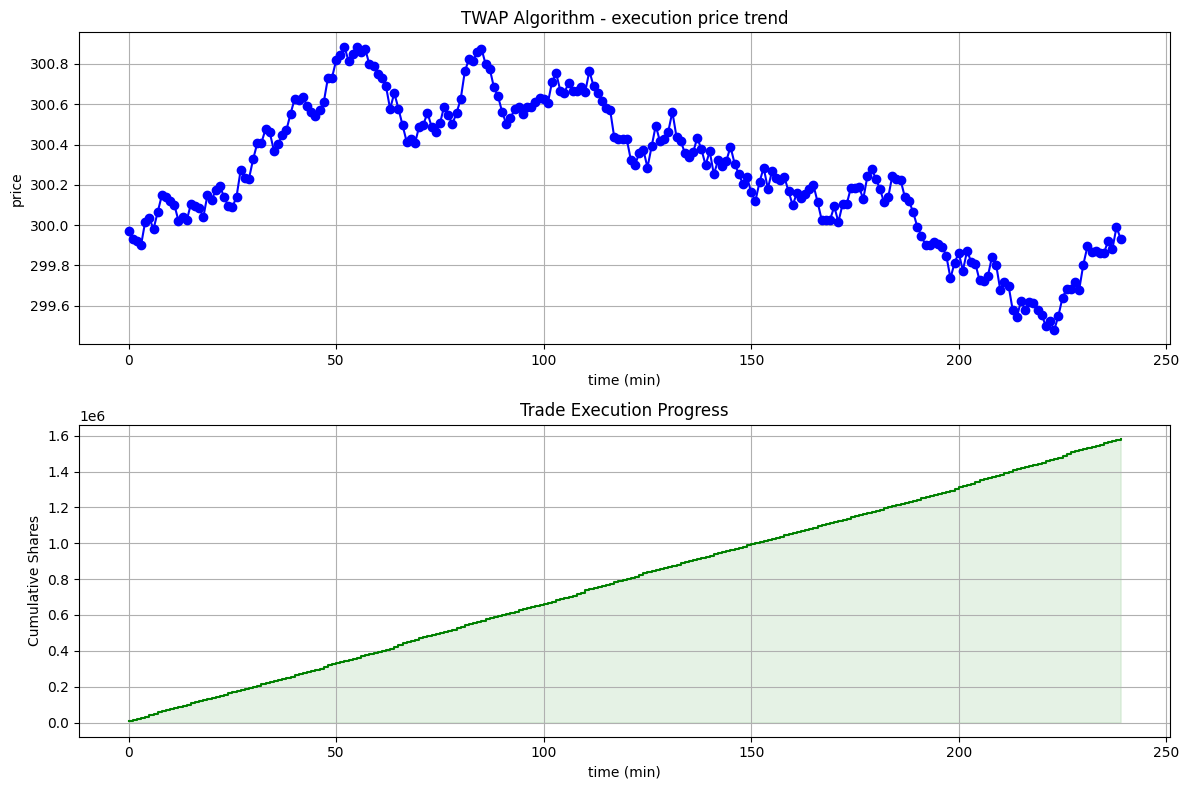

In [24]:
# 重置市场
msft_market = MarketSimulator(ticker="MSFT", base_price=300, volatility=1.5, daily_volume=5000000)
# 执行TWAP算法（带波动率调整）
twap_results = twap_algorithm(target_shares=3000000, market_data=msft_market, volatility_threshold=0.4)

2025-06-22 10:16:31 - INFO - __main__ - 
=== 启动Iceberg算法 [MSFT] ===
2025-06-22 10:16:31 - INFO - __main__ - 目标: 300.0万股 | 可见比例: 10%
2025-06-22 10:16:31 - INFO - __main__ - 执行完成! 均价: 300.88 | 隐藏量比例: 0.0%


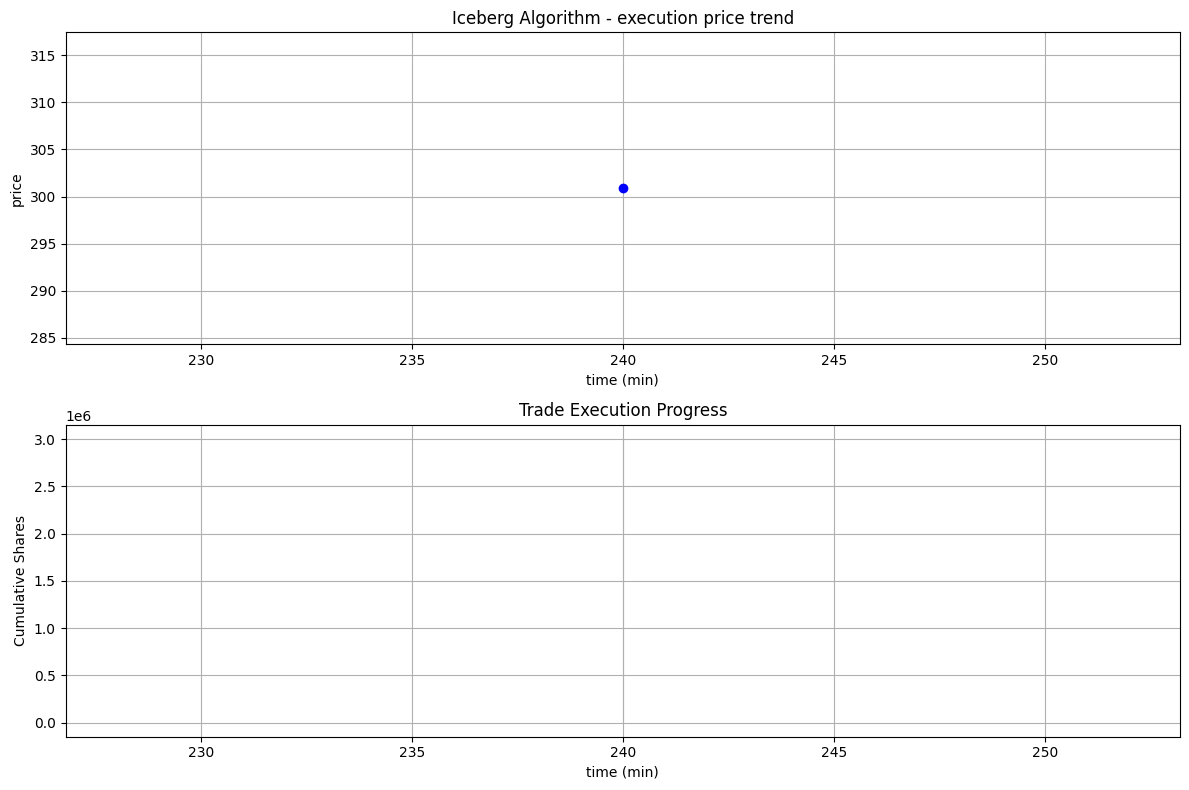

In [25]:
# 重置市场（高波动场景）
msft_market_highvol = MarketSimulator(ticker="MSFT", base_price=300, volatility=3.0, daily_volume=5000000)
# 执行Iceberg算法（10%可见）
iceberg_results = iceberg_algorithm(target_shares=3000000, market_data=msft_market_highvol, visible_ratio=0.1)

In [26]:
# 创建暗池环境
dark_pools = [
    DarkPool(name="GS SigmaX", liquidity_factor=0.6),
    DarkPool(name="MS Pool", liquidity_factor=0.3),
    DarkPool(name="Liquidnet", liquidity_factor=0.1)
]

# 执行Dark Pool算法（敏感订单）
darkpool_results = darkpool_algorithm(target_shares=3000000, market_data=msft_market, dark_pools=dark_pools)

2025-06-22 10:16:32 - INFO - __main__ - 
=== 启动Dark Pool算法 [MSFT] ===
2025-06-22 10:16:32 - INFO - __main__ - 目标: 300.0万股 | 可用暗池: GS SigmaX, MS Pool, Liquidnet


TypeError: unsupported operand type(s) for /: 'list' and 'float'